# validate masking

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/01 17:11:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/01 17:11:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Sat Mar  1 05:12:03 PM EST 2025


In [9]:
# Path and dataset names
scratch_data_path = f"{root}/scratch/plantclef/data/"
project_data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data"

# Define the path to the train and test parquet files
mask_path = f"{project_data_path}/masking/test_2024_subset20_v2"
test_df = f"{scratch_data_path}/parquet/test_2024"

# Read the parquet files into a spark DataFrame
mask_df = spark.read.parquet(mask_path)
test_df = spark.read.parquet(test_df)

# Show the data
mask_df.printSchema()
mask_df.show(vertical=True, truncate=100, n=1)

root
 |-- image_name: string (nullable = true)
 |-- leaf_mask: binary (nullable = true)
 |-- flower_mask: binary (nullable = true)
 |-- plant_mask: binary (nullable = true)
 |-- sand_mask: binary (nullable = true)
 |-- wood_mask: binary (nullable = true)
 |-- tape_mask: binary (nullable = true)
 |-- tree_mask: binary (nullable = true)
 |-- rock_mask: binary (nullable = true)
 |-- vegetation_mask: binary (nullable = true)
 |-- sample_id: integer (nullable = true)



-RECORD 0---------------------------------------------------------------------------------------------------------------
 image_name      | CBN-Pla-B2-20140722.jpg                                                                              
 leaf_mask       | [78 9C EC D8 BF AE 67 55 1D 87 E1 99 D6 AB 38 DD C1 64 0A 10 82 89 17 60 A7 A1 B1 B0 32 13 19 62 ... 
 flower_mask     | [78 9C EC D8 BF AE 67 55 1D 87 E1 99 D6 AB 38 DD C1 64 0A 10 82 89 17 60 A7 A1 B1 B0 32 13 19 62 ... 
 plant_mask      | [78 9C EC DA BB AE 6D 5B 93 25 E4 7F BB 3C C5 EF 25 48 69 14 17 15 12 0F 80 07 C2 C1 C0 42 29 2A ... 
 sand_mask       | [78 9C EC DA BB AE 6D 5B 93 25 E4 7F BB 3C C5 EF 25 48 69 14 17 15 12 0F 80 07 C2 C1 C0 42 29 2A ... 
 wood_mask       | [78 9C EC DA BB AE 6D 5B 93 25 E4 7F BB 3C C5 EF 25 48 69 14 17 15 12 0F 80 07 C2 C1 C0 42 29 2A ... 
 tape_mask       | [78 9C EC DA CB AE 65 5B 94 1D D4 1B 55 BE 22 6B 09 92 0B E6 21 23 F1 01 D4 40 54 28 50 42 16 4E ... 
 tree_mask       | [78 9C EC DA 

In [5]:
# count number of rows
mask_df.count()

10

In [10]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = test_df.limit(rows * cols).cache()
mask_subset_df = subset_df.join(mask_df, "image_name")
mask_subset_df.show(vertical=True, truncate=50, n=1)

-RECORD 0-------------------------------------------------------------
 image_name      | CBN-Pla-D3-20150811.jpg                            
 path            | /test_2024/images/CBN-Pla-D3-20150811.jpg          
 data            | [FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4... 
 leaf_mask       | [78 9C EC C8 31 0E C1 50 00 80 E1 5A 9D E2 6D 8... 
 flower_mask     | [78 9C EC C8 31 0E C1 50 00 80 E1 5A 9D E2 6D 8... 
 plant_mask      | [78 9C EC DC CD AE 74 D7 55 85 61 BB CB 55 B8 6... 
 sand_mask       | [78 9C EC DC CD AE 74 D7 55 85 61 BB CB 55 B8 6... 
 wood_mask       | [78 9C EC C8 31 0E C1 50 00 80 E1 5A 9D E2 6D 8... 
 tape_mask       | [78 9C EC C8 31 0E C1 50 00 80 E1 5A 9D E2 6D 8... 
 tree_mask       | [78 9C EC DC CD AE 74 D7 55 85 61 BB CB 55 B8 6... 
 rock_mask       | [78 9C EC DC CD AE 2D C7 41 86 61 9F 29 57 E1 9... 
 vegetation_mask | [78 9C EC DC CD AE 74 D7 55 85 61 BB CB 55 B8 6... 
 sample_id       | 0                                                  
only s

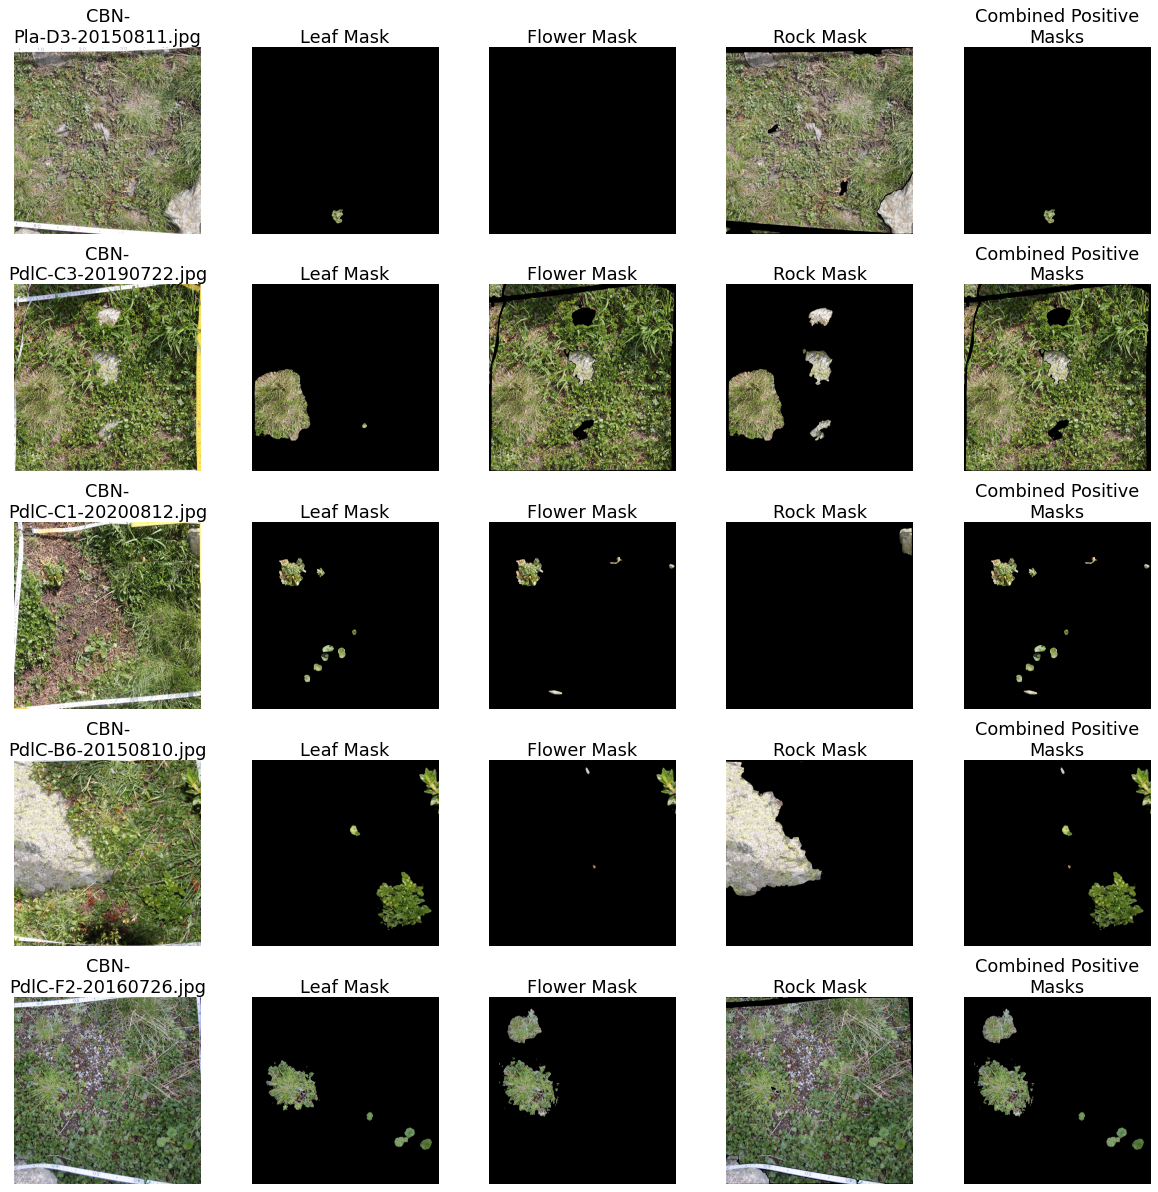

In [11]:
from plantclef.plotting import plot_individual_masks_comparison

# masks we want to display
mask_names = ["leaf_mask", "flower_mask", "rock_mask"]

plot_individual_masks_comparison(
    mask_subset_df,
    mask_names=mask_names,
    label_col="image_name",
    num_rows=5,
    figsize=(15, 15),
    wrap_width=20,
    crop_square=True,
)
# dpi=200